# SST2 Dataset Analysis
I will conduct an analysis of a dataset named SST-2, which consists of sentences and their corresponding labels. The labels represents the sentiment of the sentences.

[Dataset Link](https://huggingface.co/datasets/stanfordnlp/sst2)

In [1]:
from pyspark.sql import SparkSession

In [2]:
# Initiate Spark session
spark = SparkSession.builder \
    .appName("AnalysisOfsst2") \
    .getOrCreate()

## Read Data Files

In [3]:
# first read the parquet files into a Dataframe
df = spark.read.parquet("/content/p*.parquet")
# Convert df to RDD
rdd = df.rdd

## Data Analysis

In [4]:
# See the first 10 records
rdd.take(10)

[Row(idx=0, sentence='hide new secretions from the parental units ', label=0),
 Row(idx=1, sentence='contains no wit , only labored gags ', label=0),
 Row(idx=2, sentence='that loves its characters and communicates something rather beautiful about human nature ', label=1),
 Row(idx=3, sentence='remains utterly satisfied to remain the same throughout ', label=0),
 Row(idx=4, sentence='on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ', label=0),
 Row(idx=5, sentence="that 's far too tragic to merit such superficial treatment ", label=0),
 Row(idx=6, sentence='demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ', label=1),
 Row(idx=7, sentence='of saucy ', label=1),
 Row(idx=8, sentence="a depressed fifteen-year-old 's suicidal poetry ", label=0),
 Row(idx=9, sentence="are more deeply thought through than in most ` right-thinking ' films ", label=1)]

In [5]:
# Extract the label column to see number of labels
labels = rdd.map(lambda row: row['label'])

# Get unique labels
uniq_labels = labels.distinct().collect()

print("Unique labels:", uniq_labels)


Unique labels: [0, 1]


We can see that each record is composed of 2 items a sentence and its label representing the sentiment<br>

*   (0 = Negative 😞)
*   (1 = Positive 😃)


In [6]:
# Count the number of rows
rdd.count()

68221

Check of there is Rows with Null Values

In [7]:
null_rows = rdd.filter(lambda row: any(v is None for v in row))
print("#Rows with nulls:", null_rows.count())

#Rows with nulls: 0


Check to see if there is Rows with Empty Strings



In [8]:
empty_str_ = rdd.filter(lambda row: any(isinstance(v, str) and v.strip() == "" for v in row))
print("Rows with empty strings:", empty_str_.count())

Rows with empty strings: 0


The data doesn't have any null values

 Perform Word count on the Sentence Column

In [9]:
word_counts = rdd.flatMap(lambda row: row['sentence'].split()) \
                 .map(lambda word: (word.lower(), 1)) \
                 .reduceByKey(lambda a, b: a + b)

word_counts.take(10)

[('hide', 16),
 ('new', 698),
 ('secretions', 3),
 ('from', 1910),
 ('parental', 8),
 ('no', 1066),
 ('labored', 35),
 ('loves', 39),
 ('characters', 1172),
 ('and', 20401)]

We can also check for word count in each class of sentences positive and negative to see if they are different

In [10]:
# Map each record into (label, words) pairs
label_w_pairs = rdd.flatMap(lambda row: [(row['label'], word.lower()) for word in row['sentence'].split()])

In [11]:
# Map pair to ((label, word), 1)
label_word_1s = label_w_pairs.map(lambda pair: ((pair[0], pair[1]), 1))

In [12]:
# Reduce by the key to count each word frequencies per class
label_words_counts = label_word_1s.reduceByKey(lambda a, b: a + b)

In [13]:
# map to (label, word, count) format
counts_results = label_words_counts.map(lambda x: (x[0][0], x[0][1], x[1]))

In [14]:
# print the results sorted by most repeated words in that class
print("Top words in negative class (0):")
counts_results.filter(lambda x: x[0] == 0).sortBy(lambda x: -x[2]).take(10)

Top words in negative class (0):


[(0, 'the', 12796),
 (0, ',', 11531),
 (0, 'a', 9524),
 (0, 'and', 8013),
 (0, 'of', 7989),
 (0, 'to', 6527),
 (0, '.', 6387),
 (0, 'is', 4280),
 (0, "'s", 4209),
 (0, 'it', 3755)]

In [15]:
# print the results sorted by most repeated words in that class
print("\nTop words in positive class (1):")
counts_results.filter(lambda x: x[0] == 1).sortBy(lambda x: -x[2]).take(10)


Top words in positive class (1):


[(1, ',', 15196),
 (1, 'the', 15193),
 (1, 'a', 12620),
 (1, 'and', 12388),
 (1, 'of', 10391),
 (1, '.', 7130),
 (1, 'to', 6341),
 (1, "'s", 4830),
 (1, 'is', 4667),
 (1, 'that', 4258)]

To make the results more clear, we can remove the stop words, punctuation and short words to make the word count more meaningful by filtering out common words

In [16]:
# Load the stopwords from the NTLK libraryimport nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
# update the step above (flatMap) to remove stop words
import string

label_word_pairs = rdd.flatMap(
    lambda row: [
        (row['label'], word.lower().strip(string.punctuation))
        for word in row['sentence'].split()
        if word.lower() not in stop_words and len(word) > 2
    ]
)

In [18]:
label_word_ones = label_word_pairs.map(lambda pair: ((pair[0], pair[1]), 1))
label_word_counts = label_word_ones.reduceByKey(lambda a, b: a + b)
counts_results = label_word_counts.map(lambda x: (x[0][0], x[0][1], x[1]))

In [19]:
# print the results sorted by most repeated words in that class
print("Top words in negative class (0):")
counts_results.filter(lambda x: x[0] == 0).sortBy(lambda x: -x[2]).take(20)

Top words in negative class (0):


[(0, 'movie', 1946),
 (0, "n't", 1719),
 (0, 'film', 1542),
 (0, 'like', 1157),
 (0, 'one', 897),
 (0, 'bad', 853),
 (0, '', 685),
 (0, 'much', 618),
 (0, 'story', 606),
 (0, 'characters', 591),
 (0, 'even', 543),
 (0, 'little', 540),
 (0, 'time', 487),
 (0, 'plot', 445),
 (0, 'comedy', 437),
 (0, 'would', 428),
 (0, 'way', 428),
 (0, 'nothing', 387),
 (0, 'never', 369),
 (0, 'action', 368)]

In [20]:
# print the results sorted by most repeated words in that class
print("\nTop words in positive class (1):")
counts_results.filter(lambda x: x[0] == 1).sortBy(lambda x: -x[2]).take(20)


Top words in positive class (1):


[(1, 'film', 2617),
 (1, 'movie', 1710),
 (1, 'one', 1183),
 (1, 'good', 1021),
 (1, 'funny', 866),
 (1, 'story', 829),
 (1, '', 745),
 (1, 'best', 709),
 (1, 'like', 678),
 (1, "n't", 664),
 (1, 'love', 645),
 (1, 'comedy', 644),
 (1, 'characters', 581),
 (1, 'life', 580),
 (1, 'work', 509),
 (1, 'great', 503),
 (1, 'performances', 500),
 (1, 'enough', 490),
 (1, 'time', 477),
 (1, 'even', 475)]

We can see not that words are more meaningful like for example the words:<br>

*   love, best, great, like in the positive class.
*   Bad, little in the negative class.



To Visualize the results we can use a WordCloud to show the words in each class

In [21]:
# Collect all word counts
word_counts_all = counts_results.collect()

In [22]:
from collections import defaultdict

# make class dictionaries
freq_0 = defaultdict(int)
freq_1 = defaultdict(int)

for label, word, count in word_counts_all:
    if label == 0:
        freq_0[word] += count
    elif label == 1:
        freq_1[word] += count

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(word_freq_dict, class_label):
    class_dict = {0:"Negative",
                  1:"Positive"}

    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(word_freq_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"{class_dict[class_label]} Class WordCloud")
    plt.show()

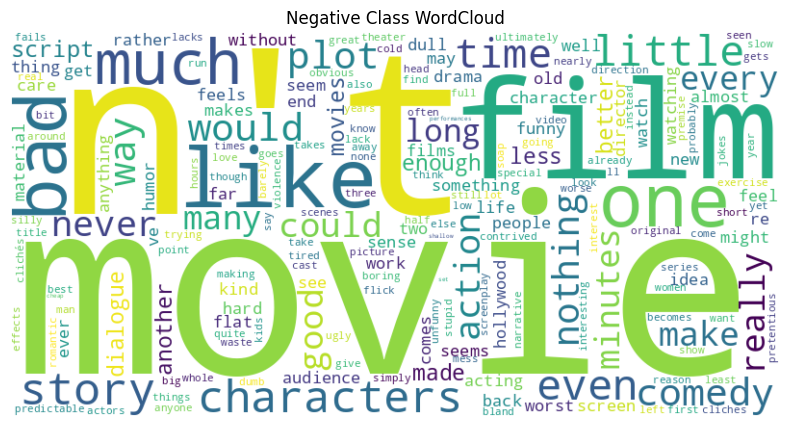

In [24]:
show_wordcloud(freq_0, 0)

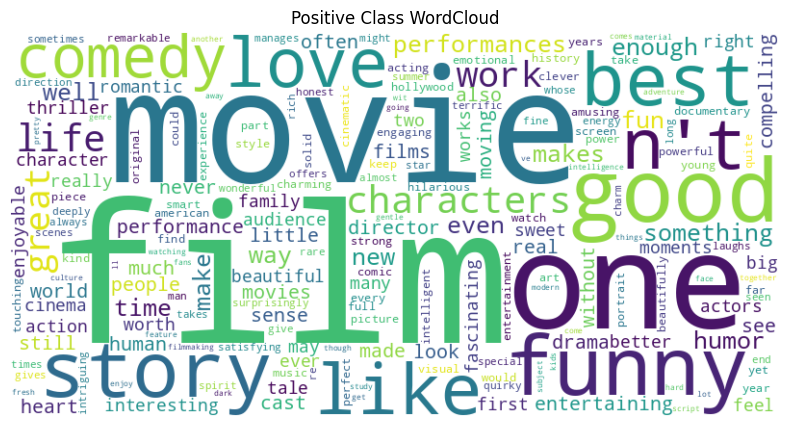

In [25]:
show_wordcloud(freq_1, 1)

Analysis of Sentence Length Distribution in each class

In [26]:
lengths_class = rdd.map(lambda row: (row.label, len(row.sentence.split())))

# Average length in class
avg_length = lengths_class \
    .groupByKey() \
    .mapValues(lambda lengths: sum(lengths) / len(lengths))

avg_length.collect()

[(0, 10.014333951271187), (1, 9.161523689264198)]

Plot histogram of length of each class

In [27]:
# Separate sentence lengths by label
lengths_0 = lengths_class.filter(lambda x: x[0] == 0).map(lambda x: x[1]).collect()
lengths_1 = lengths_class.filter(lambda x: x[0] == 1).map(lambda x: x[1]).collect()

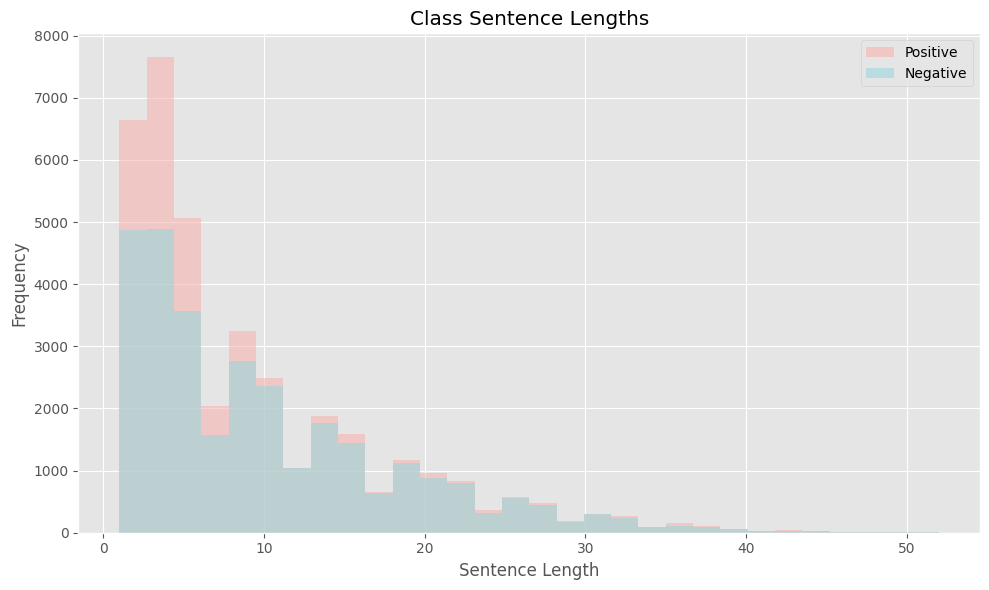

In [36]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.hist(lengths_1, bins=30, alpha=0.6, label='Positive', color='#F7B4B0')

plt.hist(lengths_0, bins=30, alpha=0.6, label='Negative', color='#9BD7DB')

plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Class Sentence Lengths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We can see the positive length is a bit bigger

Count the Vocabulary Size per Class

In [38]:
class_words = rdd.flatMap(
    lambda row: [(row.label, word.lower()) for word in row.sentence.split()]
)

# unique
vocab_per_class = class_words.distinct() \
    .groupByKey() \
    .mapValues(lambda words: len(set(words)))


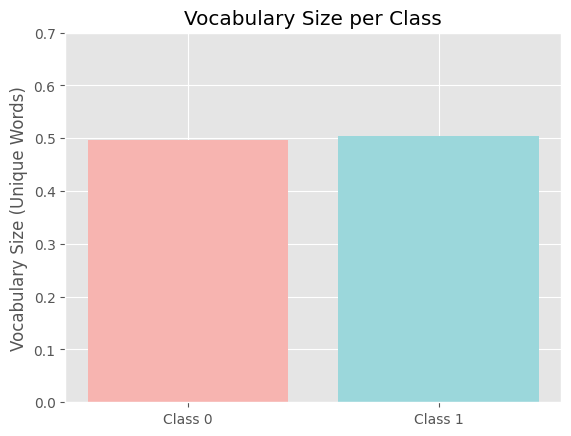

In [50]:
# Collect the small final result
vocab_counts = vocab_per_class.collect()

# Separate labels and counts
labels = [x[0] for x in vocab_counts]
counts = [x[1]/(vocab_counts[0][1] + vocab_counts[1][1]) for x in vocab_counts]

# Plot
import matplotlib.pyplot as plt

plt.bar(labels, counts, color=['#F7B4B0', '#9BD7DB'])
plt.xticks(labels, [f"Class {label}" for label in labels])
plt.ylabel("Vocabulary Size (Unique Words)")
plt.title("Vocabulary Size per Class")
plt.grid(True, axis='y')
plt.ylim(0.0,0.7)
plt.show()


The positive Class has slightly bigger vocab size

Get the Most Distinctive Words per class

In [59]:
# get Word Counts again
word_counts = rdd.flatMap(
    lambda row: [((row.label, word.lower()), 1) for word in row.sentence.split()]
).reduceByKey(lambda a, b: a + b)

# Convert to (word, (label, count))
gby_word = word_counts.map(lambda x: (x[0][1], (x[0][0], x[1])))

# group all labels for each word
groupd = gby_word.groupByKey().mapValues(list)



In [77]:
def distinctiveness(freqs):
    class_0 = class_1 = 1  # Add-one smoothing
    for label, count in freqs:
        if label == 0:
            class_0 += count
        else:
            class_1 += count
    return abs(class_0 - class_1) / (class_0 + class_1)

In [78]:
distinct = groupd.mapValues(distinctiveness)

# get results: (word, score)
distinct_sorted = distinct.sortBy(lambda x: -x[1])

In [79]:
top_dis = distinct_sorted.take(30)
top_dis

[('unfunny', 0.9827586206896551),
 ('poorly', 0.979381443298969),
 ('pointless', 0.9791666666666666),
 ('touching', 0.978494623655914),
 ('playful', 0.9764705882352941),
 ('wonderfully', 0.9746835443037974),
 ('tiresome', 0.9743589743589743),
 ('suffers', 0.972972972972973),
 ('detailed', 0.972972972972973),
 ('unnecessary', 0.972972972972973),
 ('mesmerizing', 0.9726027397260274),
 ('refreshingly', 0.9722222222222222),
 ('heartwarming', 0.9722222222222222),
 ('elegant', 0.9705882352941176),
 ('dazzling', 0.9705882352941176),
 ('badly', 0.9705882352941176),
 ('thought-provoking', 0.9696969696969697),
 ('listless', 0.96875),
 ('tender', 0.96875),
 ('worse', 0.96875),
 ('lousy', 0.9682539682539683),
 ('perfectly', 0.9661016949152542),
 ('unique', 0.9649122807017544),
 ('irritating', 0.9642857142857143),
 ('unconvincing', 0.9636363636363636),
 ('masterful', 0.9629629629629629),
 ('unimaginative', 0.9622641509433962),
 ('hearts', 0.9622641509433962),
 ('uplifting', 0.9622641509433962),
 ('

In [81]:
def plot_range_distinct(data_sorted, start_range=0, end_v=20, color='green'):
    batch = data_sorted.zipWithIndex().filter(lambda x: start_range <= x[1] < end_v).map(lambda x: x[0]).collect()
    words = [x[0] for x in batch]
    scores_vv = [x[1] for x in batch]

    plt.figure(figsize=(10, 5))
    plt.bar(words, scores_vv, color=color)
    plt.xticks(rotation=45)
    plt.title(f"Distinctive Words (Ranks from {start_range+1} to {end_v})")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


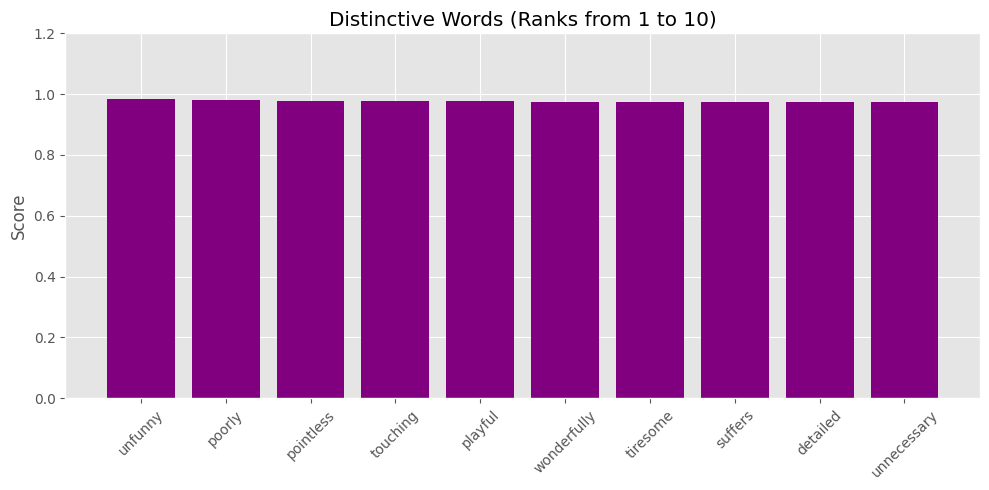

In [83]:
plot_range_distinct(distinct_sorted, 0, 10, color='purple')

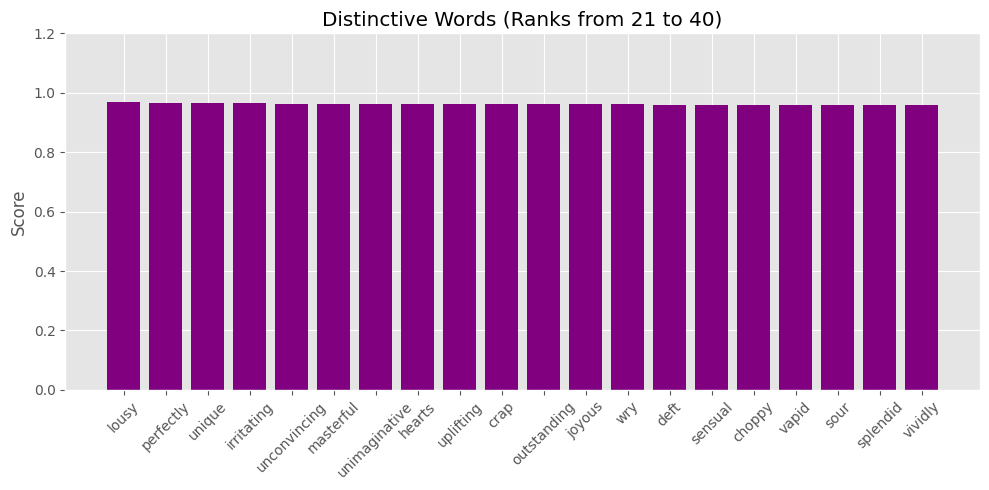

In [82]:
plot_range_distinct(distinct_sorted, 20, 40, color='purple')

###  Build a text Classification Model on the data
The goal is to make the model look at the sentence and predict its label either Positive 😃 or Negative 😞.

In [109]:
# Split the data into two sets training and testing
train_r, test_r = rdd.randomSplit([0.8, 0.2], seed=42)

In [110]:
# preprocess the data , lower case , split to words
train_rdd_processed = train_r.map(lambda row: (row.label, row.sentence.lower().split()))

In [111]:
# preprocess the data , lower case , split to words
test_rdd_processed= test_r.map(lambda row: (row.label, row.sentence.lower().split()))

In [112]:
# Compute Class Priors which is how many sentences are in each class
total_dcs = train_rdd_processed.count()
counts_class = train_rdd_processed.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b).collectAsMap()
priors__ = {cls: count / total_dcs for cls, count in counts_class.items()}

In [113]:
# Compute Word Likelihoods which is how often each word appears in each class prior knowledge
# A word might appear more times in positive and less in negative
# Flatten data
label_word_pairs_ = train_rdd_processed.flatMap(lambda x: [((x[0], word), 1) for word in x[1]])
word_cos = label_word_pairs_.reduceByKey(lambda a, b: a + b)

#  Word counts per each class
totalWords_PClass = word_cos.map(lambda x: (x[0][0], x[1])) \
                                   .reduceByKey(lambda a, b: a + b) \
                                   .collectAsMap()
# Get vocab sze
vocab = word_counts.map(lambda x: x[0][1]).distinct().collect()
vocabsize = len(vocab)


In [114]:
# Turn word counts into probabilities
likelihoods = word_counts.map(lambda x: (
    x[0],
    (x[1] + 1) / (totalWords_PClass[x[0][0]] + vocabsize)
)).collectAsMap()

In [117]:
import math
# to make a predictions, split sentence into words. then in each class, calculte the probabity
# that this clss can produce the sentence., choose the one with highest prop

def predict_function(sentence_to_predict):
    # lower case, split
    sent_split = sentence_to_predict.lower().split()
    # store prob scores of each class
    scores_prob = {}

    for cls in priors__:
        # log prior
        log_probbb = math.log(priors__[cls])
        for word in sent_split:
            # likelhood score that its from the class
            prob = likelihoods.get((cls, word), 1 / (totalWords_PClass[cls] + vocabsize))
            log_probbb += math.log(prob)
        scores_prob[cls] = log_probbb

    # Return class with highest probabity
    return max(scores_prob, key=scores_prob.get)

In [119]:
# Predict the labels of test data
test_predictions_ = test_r.map(lambda row: (row.label, predict_function(row.sentence)))

In [120]:
# Calculate the Accuracy of the model we built
# see how many of predicted == true labesl of the data
correct_preds = test_predictions_.filter(lambda x: x[0] == x[1]).count()
# get the total number of samples
total_n = test_predictions_.count()
# calculte the acc
accuracy = correct_preds / total_n
print(f"Accuracy on Test: {accuracy:.2f}")

Accuracy on Test: 0.88


Test on random sentences

In [130]:
dict_map = {0:"Negative",
            1:"Positive"}

In [132]:
test_sentence_neg = "this movie was absolutely sad and devasting"

predicted_ = predict_function(test_sentence_neg)
print(f"Predicted Class {dict_map[predicted_]}")


Predicted Class Negative


In [133]:
test_sentence_pos = "I watched a movie that was absolutely amazing and heartwarming"

predicted_ = predict_function(test_sentence_pos)
print(f"Predicted Class {dict_map[predicted_]}")


Predicted Class Positive
